In [1]:
# This notebook is used to find a network from a list of nodes in Translator

In [1]:
from TCT import name_resolver
from TCT import node_normalizer
from TCT import translator_metakg
from TCT import translator_kpinfo
from TCT import TCT

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import pandas as pd
import  seaborn as sns
import networkx as nx
import numpy as np
import ipycytoscape
import yaml

In [2]:
# Preparation 
# Step1: List all the APIs in the translator system
Translator_KP_info,APInames= translator_kpinfo.get_translator_kp_info()
print(len(Translator_KP_info))
# Step 2: Get metaKG and all predicates from Translator APIs through the SmartAPI system
metaKG = translator_metakg.get_KP_metadata(APInames) 
print(metaKG.shape)
# Add metaKG from Plover API based KG resources
APInames,metaKG = translator_metakg.add_plover_API(APInames, metaKG)
print(metaKG.shape)
# Step 3: list metaKG information
All_predicates = list(set(metaKG['Predicate']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))
API_withMetaKG = list(set(metaKG['API']))
print(len(API_withMetaKG))
print(len(All_predicates))
print(len(All_categories))

# ARA list
API_withMetaKG = set(metaKG['API'])
print("ARA list:", set(APInames.keys()) - API_withMetaKG)
# find the KG in one individual API (optional)
#metaKG.loc[metaKG['API'] == 'CATRAX Pharmacogenomics KP - TRAPI 1.5.0',['API','Predicate','Subject','Object']].drop_duplicates()

53
(10580, 5)
(22129, 5)
42
184
108
ARA list: {'Cqs(Trapi v1.5.0)', 'ARAX Translator Reasoner - TRAPI 1.5.0', 'Aragorn(Trapi v1.5.0)', 'Sri-node-normalizer(Trapi v1.5.0)', 'Sri-answer-appraiser(Trapi v1.5.0)', 'Workflow-runner(Trapi v1.5.0)', 'Autonomous Relay System (ARS) TRAPI', 'OpenPredict API', 'mediKanren', 'Answer-coalesce(Trapi v1.5.0)'}


In [5]:
# Step 3: set input parameters

# Node1 for query
#input_node1 = 'NPM1'
#input_node1_id = TCT.get_curie(input_node1)
#print(input_node1_id)
input_node1_info = name_resolver.lookup("NPM1")
input_node2_info = name_resolver.lookup("FLT3")
input_node3_info = name_resolver.lookup("NRAS")
input_node4_info = name_resolver.lookup("BCL2")
input_node1_list = [input_node1_info.curie, input_node2_info.curie, input_node3_info.curie, input_node4_info.curie]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Gene', 'biolink:Protein', 'biolink:ChemicalSubstance', 'biolink:Drug', 'biolink:DiseaseOrPhenotypicFeature']


# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,obj_list=input_node2_category,metaKG=metaKG)))
sele_predicates = ['biolink:genetically_associated_with', 'biolink:genetic_association', 
                   'biolink:genetically_interacts_with', 'biolink:physically_interacts_with',
                   'biolink:interacts_with',  'biolink:directly_physically_interacts_with','biolink:binds', ]
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,obj_list=input_node2_category,metaKG=metaKG)
print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

#sele_APIs = ['Multiomics BigGIM-DrugResponse KP API']
sele_APIs = sele_APIs
# get API URLs : two options: filter by API names or filter by predicates
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

all relevant predicates in Translator:
['biolink:genetically_associated_with', 'biolink:genetic_association', 'biolink:genetically_interacts_with', 'biolink:physically_interacts_with', 'biolink:interacts_with', 'biolink:directly_physically_interacts_with', 'biolink:binds']
all relevant APIs in Translator:
['MolePro', 'BioThings Explorer (BTE) TRAPI', 'RTX KG2 - TRAPI 1.5.0', 'Automat-monarchinitiative(Trapi v1.5.0)', 'CATRAX BigGIM DrugResponse Performance Phase KP - TRAPI 1.5.0', 'Automat-ehr-clinical-connections-kp(Trapi v1.5.0)', 'imProving Agent for TRAPI 1.5', 'Service Provider TRAPI', 'Automat-robokop(Trapi v1.5.0)', 'Automat-ehr-may-treat-kp(Trapi v1.5.0)', 'CATRAX Pharmacogenomics KP - TRAPI 1.5.0', 'Automat-cam-kp(Trapi v1.5.0)', 'Automat-hetionet(Trapi v1.5.0)', 'SPOKE KP for TRAPI 1.5', 'Automat-genome-alliance(Trapi v1.5.0)', 'Microbiome KP - TRAPI 1.5.0', 'Automat-pharos(Trapi v1.5.0)', 'Automat-icees-kg(Trapi v1.5.0)', 'Connections Hypothesis Provider API', 'Multiomics KP

In [6]:
len(API_URLs)

20

In [7]:
#URLS_sele = filter_APIs(sele_predicates, metaKG)

In [7]:
# Step 4: Format query json
# not consider the category of input_node 1
query_json1 = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   [],  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates
# specify the category of input_node1
query_json2 = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of pre

In [21]:
# Step 5: Query Translator APIs and parse results
result1 = TCT.parallel_api_query(API_URLs,query_json=query_json1, max_workers=len(API_URLs))

#

Warning Code:422:https://automat.renci.org/ehr-clinical-connections-kp/query/
Warning Code:404:https://spokekp.transltr.io/api/v1.5/query/
Success!https://automat.transltr.io/cam-kp/query/
Warning Code:404:https://ia.transltr.io/api/v1.5/query/
Success!https://automat.transltr.io/monarch-kg/query/
Warning Code:422:https://automat.transltr.io/icees-kg/query/
Warning Code:422:https://automat.transltr.io/genome-alliance/query/
Success!https://chp-api.transltr.io/query/
Success!https://automat.transltr.io/pharos/query/
Warning Code:422:https://automat.renci.org/ehr-may-treat-kp/query/
Success!https://automat.transltr.io/hetio/query/
Success!https://multiomics.rtx.ai:9990/mbkp/query
Warning Code:404:https://molepro-trapi.transltr.io/molepro/trapi/v1.5/query/
Warning Code:404:https://multiomics.rtx.ai:9990/multiomics/query
Success!https://multiomics.rtx.ai:9990/PharmacogenomicsKG/query
Success!https://kg2cploverdb.ci.transltr.io/kg2c/query
Success!https://multiomics.rtx.ai:9990/BigGIM_DrugRe

In [22]:
result = result1

In [23]:
result_df = TCT.parse_network_result(result, input_node1_list)

Text(0.5, 1.0, 'Frequency of Subject Categories in the Network')

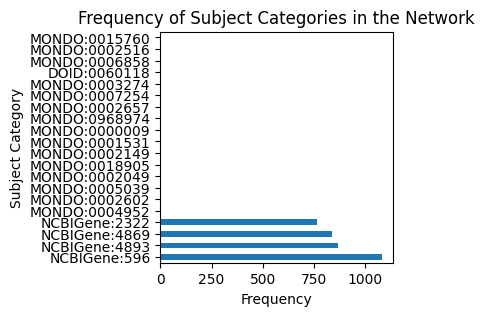

In [27]:
result_df
# count the frequency of subjects 
result_df['Subject'].value_counts().head(20).plot(kind='barh', figsize=(3, 3))
plt.xlabel('Frequency')
plt.ylabel('Subject Category')
plt.title('Frequency of Subject Categories in the Network')

Text(0.5, 1.0, 'Frequency of Object Categories in the Network')

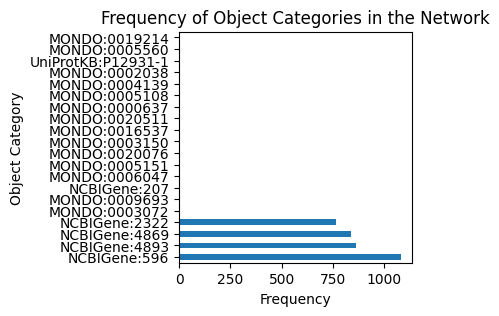

In [28]:
result_df['Object'].value_counts().head(20).plot(kind='barh', figsize=(3, 3))
plt.xlabel('Frequency')
plt.ylabel('Object Category')
plt.title('Frequency of Object Categories in the Network')

In [32]:
TCT.visulize_path(TCT.get_curie("NPM1"), "MONDO:0004952", TCT.get_curie("FLT3"), result, result)


CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'Path', 'nodeSpacing': 80, 'edgeLengthVal': 50}, cy…

,Subject,Object,Predicates,Subject_name,Object_name
0,NCBIGene:4869,MONDO:0004952,gene_associated_with_condition::infores:diseases,NPM1,Hodgkin Disease
1,NCBIGene:2322,MONDO:0004952,gene_associated_with_condition::infores:diseases,FLT3,Hodgkin Disease


In [14]:
#TCT.plot_graph_by_predicates(result_df)